In [1]:
# import modules
#%matplotlib inline
import os
#from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
import xarray as xr
#from scipy.fft import fft, ifft, fftfreq
#from scipy import signal
#from mpi4py import MPI
import h5py
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

import re
pattern = re.compile(r'\d+') 

In [2]:
#%%file function_definitions.py

# import numpy as np
# import matplotlib.pyplot as plt
# import xarray as xr
# from scipy.fft import fft
# function definitions

#This function is modified to return Xarray instead of Dictionary. 
def read_cbd(file_path):
    '''
    read_cbd: reads the cbd file data
    Arguments:
    file_path-- path where the file is located
    Return--
    xr_data-- data_matrix: 3-D matrix of size (N_x, N_y, N_z)
          x-coord: 1-D array of  x-coordinates size (N_x,1)
          y-coord: 1-D array of  y-coordinates size (N_y,1)
          z-coord: 1-D array of  z-coordinates size (N_z,1)
    '''
    f = open(file_path, "rb")
    id = np.fromfile(f, dtype=np.int64, count=1)[0]
    if id == 288230376151834571:
        T = np.float32
    elif id == 576460752303546315:
        T = np.float64
    else:
        raise ValueError("Invalid ID")
    N = tuple(np.fromfile(f, dtype=np.int64, count=3))
    xmin = tuple(np.fromfile(f, dtype=np.float64, count=3))
    xmax = tuple(np.fromfile(f, dtype=np.float64, count=3))
    x1, x2, x3 = (np.fromfile(f, dtype=np.float64, count=n) for n in N)
    data1 = np.fromfile(f, dtype=T, count=np.prod(N)).reshape(N, order="F")
    #dic = {"data":data1, "x-coord":x1, "y-coord":x2, "z-coord":x3, "diagonal_points":[xmin,xmax]}
    xr_data = xr.DataArray(
        data1,
        dims = ("x", "y", "z"),
        coords = { "x" : x1,
                  "y" : x2,
                  "z" : x3
        }   
    )
    f.close()
    return xr_data

def h5_in_xarray(field):
    #hf = h5py.File(filepath, 'r')
    data = hf.get('%s' % field)
    x1 = hf.get('x-coord')
    x2 = hf.get('y-coord')
    x3 = hf.get('z-coord')
    xr_data = xr.DataArray(
        np.array(data),
        dims = ("x", "y", "z"),
        coords = { "x" : np.array(x1),
                  "y" : np.array(x2),
                  "z" : np.array(x3)
        }   
    )
    
    return xr_data

def create_xarray(u):
    
    # This function creates an xarray that has same data size and coordinates aligned with the input xarray u
    new_array = xr.DataArray(
        np.empty(u.shape),
        dims = ("x", "y", "z"),
        coords = { "x" : u['x'],
              "y" : u['y'],
              "z" : u['z']
        }
    )
    
    return new_array

def intp_w_to_uvp(w, u):
    
    # This function interpolates w to uvp nodes
    w_intp = create_xarray(u)
    w_intp[:, :, :-1] = w.interp(z = u['z'][:-1])
    w_intp[:, :, u['z'].size - 1] = 0
    
    return w_intp

def u_log(z, d, z0):
        return (0.45 / 0.4) * np.log((z - d) / z0)
    
def compute_stresses(prefix, suffix_list, field_list, filepath):
    f = {}  # A dictionary to hold all the variables
    
    i = 0
    for suffix in suffix_list:
        for field in field_list:

            fp = "%s/%s_%s%s.h5" % (filepath, prefix, field, suffix) 
            f["%s%d" % (field, i)] = h5_in_xarray(fp)

        i += 1
    del i
    
    dc = {}  # A dictionary to store dispersive covariances
    rs = {}  # A dictionary to store Reynolds stresses
    sub = {} # A dictionaty to store subgrid stresses
    stress = {} # To store total stresses
    
    for j in range(len(suffix_list)):
        dc["uw%d" % (j)] = (f["u%d" % (j)]*f["w%d" % (j)]).mean(dim = ['x', 'y']) - f["u%d" % (j)].mean(dim = ['x', 'y']) * f["w%d" % (j)].mean(dim = ['x', 'y'])
        rs["uw%d" % (j)] = f["uw%d" % (j)].mean(dim = ['x', 'y']) - (f["u%d" % (j)] * f["w%d" % (j)]).mean(dim = ['x', 'y'])

    i = 0
    for suffix in suffix_list:
        fp = "%s/%s_txz%s.h5" % (filepath, prefix, suffix) 
        sub["uw%d" % (i)] = h5_in_xarray(fp)
        sub["uw%d" % (i)] = intp_w_to_uvp(sub["uw%d" % (i)], f["u%d" % (i)]).mean(dim = ['x', 'y'])
        i += 1
    del i
    
    # Calculating the totla stress
    for j in range(len(suffix_list)):
        stress["uw_%d" % (j)] = dc["uw%d" % (j)] + rs["uw%d" % (j)] + sub["uw%d" % (j)]
        
    return f, dc, rs, sub, stress

In [3]:
# Let's load the entire data
#field_list = ['u', 'v', 'w', 'uu', 'uv', 'uw', 'vv', 'vw', 'ww']
path = '/home/as2204/TACC_postprocess'
f = {} # Loads all the variables
#h5_files = ['chan_l4_8x24x48.h5']
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "rvv" in match and "_16x" not in match and "_12x" not in match]
filepath = '%s/pressure_corrected_domain_averages' % path

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    #for field in field_list:
    f['rvv%s' % (sim[8:-3])] = h5_in_xarray('v_rii')

In [4]:
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and "_16x" in match and 'rvv' in match and 'run2' not in match]
for sim in h5_files:
    sim = sim[8:-12]
    print("%s" % sim)
    i = 0
    sim_name = "rvv_chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    #for field in field_list:
    f['rvv%s' % (sim)] = h5_in_xarray('v_rii')
    
    for i in range(1, 4):
        sim_name = "rvv_chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        #for field in field_list:
        f['rvv%s' % (sim)] += h5_in_xarray('v_rii')

    if "l2_16x48" in sim or "l2_16x72" in sim:
        print("%s" % sim)
        for i in range(4):
            sim_name = "rvv_chan%s_restart%d_run2.h5" % (sim, i)
            # print(sim_name)
            hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
            #for field in field_list:
            f['rvv%s' % (sim)] += h5_in_xarray('v_rii')
        
        #for field in field_list:
        f['rvv%s' % (sim)] /= 8
    else:
        #for field in field_list:
        f['rvv%s' % (sim)] /= 4

_l2_16x24x96
_l6_16x48x96
_l4_16x24x96
_l12_16x72x96
_l4_16x72x96
_l12_16x24x96
_l2_16x72x96
_l2_16x72x96
_l2_16x48x96
_l2_16x48x96
_l6_16x24x96
_l4_16x48x96
_l12_16x48x96
_l6_16x72x96


In [5]:
h5_files = os.listdir('%s/longerx_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and 'rvv' in match and 'run2' not in match]
filepath = '%s/longerx_averages' % path
for sim_ in h5_files:
    pattern = re.search('rvv_chan(_l\d+_\d+x\d+x\d+)_.*', sim_)
    sim = pattern.group(1)
    i = 0
    sim_name = "rvv_chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    #for field in field_list:
    f['rvv%s' % (sim)] = h5_in_xarray('v_rii')
    
    for i in range(1, 4):
        sim_name = "rvv_chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        #for field in field_list:
        f['rvv%s' % (sim)] += h5_in_xarray('v_rii')
        
    #for field in field_list:
    f['rvv%s' % (sim)] /= 4

In [6]:
# Loading variance data
field_list = ['v', 'vv']
#f = {} # Loads all the variables
#h5_files = ['chan_l4_8x24x48.h5']
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "chan" in match and "_16x" not in match and "_12x" not in match and "ruu" not in match and "rvv" not in match]
filepath = '%s/pressure_corrected_domain_averages' % path

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)
        
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and "_12x" not in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
for sim in h5_files:
    sim = sim[4:-12]
    print("%s" % sim)
    i = 0
    sim_name = "chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    for field in field_list:
        f['%s%s' % (field, sim)] = h5_in_xarray(field)
    
    for i in range(1, 4):
        sim_name = "chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        for field in field_list:
            f['%s%s' % (field, sim)] += h5_in_xarray(field)

    if "l2_16x48" in sim or "l2_16x72" in sim:
        for i in range(4):
            sim_name = "chan%s_restart%d_run2.h5" % (sim, i)
            print(sim_name)
            hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
            for field in field_list:
                f['%s%s' % (field, sim)] += h5_in_xarray(field)
        
        for field in field_list:
            f['%s%s' % (field, sim)] /= 8
    else:
        for field in field_list:
            f['%s%s' % (field, sim)] /= 4


h5_files = os.listdir('%s/longerx_averages' % path)
filepath = '%s/longerx_averages' % path
h5_files = [match for match in h5_files if "restart0" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
for sim in h5_files:
    sim = sim[4:-12]
    print("%s" % sim)
    i = 0
    sim_name = "chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    for field in field_list:
        f['%s%s' % (field, sim)] = h5_in_xarray(field)
    
    for i in range(1, 4):
        sim_name = "chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        for field in field_list:
            f['%s%s' % (field, sim)] += h5_in_xarray(field)

    for field in field_list:
        f['%s%s' % (field, sim)] /= 4

_l2_16x48x96
chan_l2_16x48x96_restart0_run2.h5
chan_l2_16x48x96_restart1_run2.h5
chan_l2_16x48x96_restart2_run2.h5
chan_l2_16x48x96_restart3_run2.h5
_l6_16x24x96
_l4_16x48x96
_l12_16x48x96
_l6_16x72x96
_l2_16x24x96
_l12_16x24x96
_l6_16x48x96
_l4_16x24x96
_l12_16x72x96
_l4_16x72x96
_l2_16x72x96
chan_l2_16x72x96_restart0_run2.h5
chan_l2_16x72x96_restart1_run2.h5
chan_l2_16x72x96_restart2_run2.h5
chan_l2_16x72x96_restart3_run2.h5
_l4_16x72x144
_l2_16x72x144
_l6_16x72x144


In [7]:
# Now, I need to load the uu variance to normalize autocorrelation
h5_files_list = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match[4:-3] for match in h5_files_list if "_16x" not in match and "_12x" not in match and "chan" in match and "ruu" not in match and "rvv" not in match]
h5_files_16 = [match[4:-12] for match in h5_files_list if "restart0" in match and "_16x" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
# h5_files += h5_files_16 + [match[4:-3] for match in h5_files_list if "16x48x48" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
h5_files_longerx = os.listdir('%s/longerx_averages' % path)
h5_files_longerx = [match[4:-12] for match in h5_files_longerx if "restart0" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
h5_files += h5_files_longerx + h5_files_16

var_list = ['vv']
temp = {}

for sim in h5_files:
    for v in var_list:
        temp["%s%s" % (v, sim)] = f["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (f["%s%s" % (v[0], sim)] * f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])
        
disp = {}

for sim in h5_files:
    for v in var_list:
        disp["%s%s" % (v, sim)] = (f["%s%s" % (v[0], sim)]*f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - f["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * f["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])
        
stress = {}

for sim in h5_files:
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]     

In [8]:
key_list = list(f.keys())
key_list = [match[4:] for match in key_list if "rvv" in match]
# print(key_list)
# print(stress.keys())

In [9]:
norm_rii={}

for key in key_list:
    norm_rii["%s" % key] = f["rvv_%s" % key] / stress["vv_%s" % key]

In [10]:
def shift_quadrants(xarray):
    shifted_array = np.empty(xarray.shape)
    lx = int(len(xarray['x']) / 2)
    ly = int(len(xarray['y']) / 2)
    
    shifted_array[:lx, :ly, :] = xarray[lx:, ly:, :].values
    shifted_array[lx:, :ly, :] = xarray[:lx, ly:, :].values
    shifted_array[:lx, ly:, :] = xarray[lx:, :ly, :].values
    shifted_array[lx:, ly:, :] = xarray[:lx, :ly, :].values
    
    shifted_x = xarray['x'] - (xarray['x'][-1]) / 2
    shifted_y = xarray['y'] - (xarray['y'][-1]) / 2
    return shifted_array, shifted_x, shifted_y

def contour_rii(key):
    z_locs = [0.3, 0.5, 0.7]
    match = pattern.findall(key)
    
    norm_rii['%s' % key] = norm_rii['%s' % key] / norm_rii['%s' % key].max()
    lx = int(len(norm_rii['%s' % key]['x']) / 2)
    ly = int(len(norm_rii['%s' % key]['y']) / 2)
    quad = norm_rii['%s' % key][:lx, :ly, :]
    
    for z in z_locs:
        X, Y = np.meshgrid(quad['x'], quad['y'])
        CS = plt.contour(X, Y, quad.values[:, :, int(z * int(match[1]) * 8)].transpose(), colors = '#FFFFF0', vmax=1)
        plt.contourf(X, Y, quad.values[:, :, int(z * int(match[1]) * 8)].transpose(), vmax=1)
        plt.clabel(CS, CS.levels, inline=True, fontsize=10, colors = 'w')
        plt.colorbar()
        plt.title("Rvv - z=%dh - config %sx%sx%s - packing density l%s" % (z * 100, match[1], match[2], match[3], match[0]))
        plt.savefig("rvv - z=%dh - config %sx%sx%s - packing density l%s.png" % (z * 100, match[1], match[2], match[3], match[0]), dpi=300)
        plt.close()
    return None

def contour_ruu_2(key, z_locs):
    # z_locs = [0.3, 0.5, 0.7]
    pattern = re.compile(r'\d+')
    match = pattern.findall(key)
    
    norm_rii['%s' % key] = norm_rii['%s' % key] / norm_rii['%s' % key].max()
    shifted_norm, shifted_x, shifted_y = shift_quadrants(norm_rii['%s' % key])
    
    for z in z_locs:
        X, Y = np.meshgrid(shifted_x, shifted_y)
        # CS = plt.contour(X, Y, shifted_norm[:, :, int(z * int(match[1]) * 8)].transpose(), colors = '#FFFFF0', vmax=1)
        if "144" not in key:
            CS = plt.contour(X, Y, shifted_norm[:, :, int(z * int(match[1]) * 8)].transpose(), levels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8], vmax=1, vmin=-1, cmap='coolwarm')
        else:
            CS = plt.contour(X, Y, shifted_norm[:, :, int(z * int(match[1]) * 8)].transpose(), levels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8], vmax=1, vmin=-1, cmap='coolwarm')
        # plt.contourf(X, Y, shifted_norm[:, :, int(z * int(match[1]) * 8)].transpose(), vmax=1, cmap='turbo')
        plt.clabel(CS, CS.levels, inline=True, fontsize=10, fmt='%.1f', colors = 'k')
        # plt.colorbar()
        #plt.title("Ruu - z=%dh - config %sx%sx%s - packing density l%s" % (z * 100, match[1], match[2], match[3], match[0]))
        plt.xlabel('x')
        plt.ylabel('y')
        # plt.savefig("hopefully_final_results/rvv_shifted - z=%dh - config %sx%sx%s - packing density l%s.png" % (z * 100, match[1], match[2], match[3], match[0]), dpi=300)
        # plt.close()
    return None

In [11]:
# Now I need to find out the integral length scale based on quadrant data
def output_quadrant(key):
    
    norm_rii['%s' % key] = norm_rii['%s' % key] / norm_rii['%s' % key].max()
    lx = int(len(norm_rii['%s' % key]['x']) / 2)
    ly = int(len(norm_rii['%s' % key]['y']) / 2)
    quadrant = norm_rii['%s' % key][:lx, :ly, :]
    
    return quadrant

def output_xloc(xarray, z, cutoff_val):
    # This function outputs xloc of cutoff value for a given z
    for i in range(xarray['x'].size):
        if xarray[i, 0, z] < cutoff_val:
            break;
    
    return i

def output_yloc(xarray, z, cutoff_val):
    # This function outputs xloc of cutoff value for a given z
    for i in range(xarray['y'].size):
        if xarray[0, i, z] < cutoff_val:
            break;

    # also calculating residual length (which is smaller than the grid size based on interpolation)
    left_val = xarray[0, i-1, z].values
    right_val = xarray[0, i, z].values
    dr = (xarray['y'][1] - xarray['y'][0]).values
    delta_req   = left_val - cutoff_val
    delta_grid = left_val - right_val
    residual = dr * delta_req / delta_grid 
    return i , residual

def calc_L11(xarray):
    # Calculating integral length scale for the quadrant
    
    znodes = xarray['z'].size 
    l = np.empty(znodes)
    dr = xarray['x'][1] - xarray['x'][0]

    for i in range(znodes):
        x_loc = output_xloc(xarray, i, 0.5)
        l[i] = np.sum(xarray[:x_loc, 0, i]) * dr.values
    
    return l

def calc_L22(xarray, cutoff):
    # Calculating integral length scale for the quadrant
    
    znodes = xarray['z'].size 
    l = np.empty(znodes)
    dr = xarray['y'][1] - xarray['y'][0]
    
    for i in range(znodes):
        y_loc, residual = output_yloc(xarray, i, cutoff)
        l[i] = np.sum(xarray[0, :y_loc - 1, i]) * dr.values  + xarray[0, y_loc - 1, i] * residual
    
    return l

### Figure 6

Text(0.055, 0.5, '$x_3/L_3$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


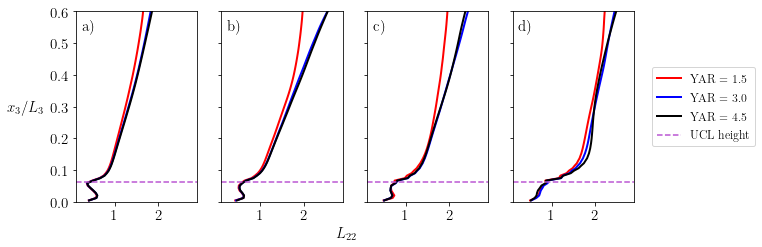

In [12]:
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
pattern = re.compile(r'\d+')

fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3.5), sharey=True)

pack_list = ["l2", "l4", "l6", "l12"]
for index, pack_den in enumerate(pack_list):   
    key_list = ["%s_16x24x96" % pack_den, "%s_16x48x96" % pack_den, "%s_16x72x96" % pack_den]
    # print(key_list)
    # ax1 = fig1.add_subplot(111)
    # number_of_plots = 5
    # # colormap = cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,minLight=.3,maxLight=.8,gamma=.9)
    # colormap = cubehelix.cmap(start=0.5 , rotation=-1.0, hue=1, gamma=1.0)  # works well with number of plots 5
    # # colormap = plt.cm.cubehelix #I suggest to use nipy_spectral, Set1,Paired
    # axs[index].set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])
    namelist = ['a)', 'b)', 'c)', 'd)']
    clist = ['r', 'b', 'k']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[1])
        ly = int(match[2])
        quadrant = output_quadrant(key)
        l22 = calc_L22(quadrant, 0.4)
        if index == 3:
            axs[index].plot(l22[:80], quadrant['z'][:80] / delta, clist[index1], linewidth=2, label='YAR = %.1f' % float(ly/delta))
        else:
            axs[index].plot(l22[:80], quadrant['z'][:80] / delta, clist[index1], linewidth=2)
    plt.text(0.1, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 0.6)
    axs[index].set_xlim(0.1, 2.9)
    axs[index].set_xticks([1, 2])
    axs[index].plot(np.linspace(0.1, 2.9, 20), np.ones(20) * 1/delta, color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
axs[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
# axs[0].set_xticks([0.75, 1.75])
fig1.text(0.5, 0, r'$L_{22}$', ha='center', va='center', fontsize=15)
fig1.text(0.055, 0.5, r'$x_3/L_3$', ha='center', va='center', rotation='horizontal', fontsize=15)
# plt.tight_layout()
# fig1.savefig('eps_figs/L22_limupdated.pdf', format='pdf', bbox_inches="tight")